# Import data

In [2]:
local_data = pd.read_csv("data/processed/country_temp_gdp_traffic_fatalities.csv")

# PyMC Models

## Build joint temp-gdp model

In [10]:
with pm.Model() as model:
    
    temp_prior = pm.Normal("temp_prior", 0, 30, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 30, shape=3)
    temp_mixture_weights = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_posterior = pm.NormalMixture("temp_posterior", temp_mixture_weights, temp_prior, temp_std, observed=local_data["Temp"])
    
    temp_coef = pm.Normal('temp_coef',0,10)
    temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    temp_intercept = pm.Normal('temp_intercept',0,10)
    
    gdp_prior = pm.Deterministic("gdp_prior", temp_intercept + (temp_coef * temp_posterior) + (temp_coef_2 * pt.sqr(temp_posterior)))
    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=local_data["GDP_change"])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in traffic_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16D675580>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable Ran

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 170 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x44D62D2E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x44D6BFD60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_posterior_observed, traffic_posterior_observed, traffic_posterior_unobserved]


In [202]:
# What change in gdp can a country expect at various temperatures?
temp_ranges = [(5,10), (25, 30)]
num_samples = 1
for temp_range in temp_ranges:
    print("Temp range:", temp_range)
    gdp_change = []
    for dist in range(num_samples):
        for sample in range(len(local_data["Temp"])):
            temp_val = posterior["posterior"]["temp_posterior"][1].data[dist][sample]
            if temp_val >= temp_range[0] and temp_val <= temp_range[1]:
                gdp_change.append(posterior["posterior"]["gdp_posterior"][1].data[dist][sample])
    print("Average gdp change:", np.mean(gdp_change))
    print("GDP change Std. Error:", np.std(gdp_change))
    print("Number of samples:", len(gdp_change))

Temp range: (5, 10)
Average gdp change: 0.022594531236020468
GDP change Std. Error: 0.06378747633740157
Number of samples: 1317
Temp range: (25, 30)
Average gdp change: 0.011212342950222626
GDP change Std. Error: 0.06232698778222426
Number of samples: 3206


# Plots to show the overlap of regression equation, observed data, and sampled data for temp X gdp

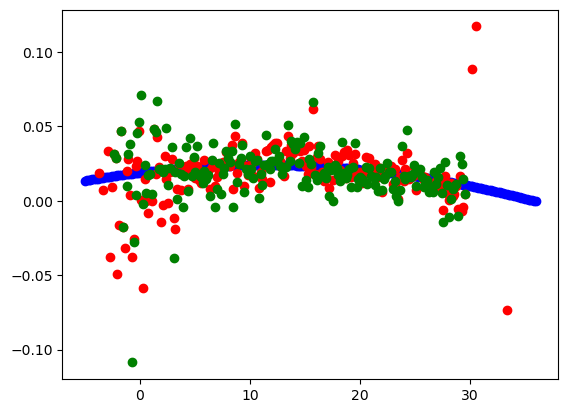

In [198]:
# takes some time to run due to the nested loops
x_vals = []
regression_y_vals = []
sampled_y_vals = []
observed_y_vals = []

for temp in np.linspace(-5,36,num=250):  
    x_vals.append(temp)
    regression_y_vals.append((.0009 * temp) - (.00004 * (temp**2)) + .019)
    sampled_gdp_change = []
    for sample in range(len(local_data["Temp"])):
        temp_val = posterior["posterior"]["temp_posterior"][1].data[0][sample]
        if temp_val >= temp-.08 and temp_val <= temp+.08:
            sampled_gdp_change.append(posterior["posterior"]["gdp_posterior"][1].data[0][sample])
    sampled_y_vals.append(np.mean(sampled_gdp_change))
    observed_gdp_change = []
    for index, observed_temp in enumerate(local_data["Temp"]):
        if observed_temp >= temp-.08 and observed_temp <= temp+.08:
            if not np.isnan(local_data["GDP_change"][index]):
                observed_gdp_change.append(local_data["GDP_change"][index])
    observed_y_vals.append(np.mean(observed_gdp_change))
    
plt.scatter(x_vals, regression_y_vals, color="blue")
plt.scatter(x_vals, sampled_y_vals, color="red")
plt.scatter(x_vals, observed_y_vals, color="green")
plt.show()

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_17407/4201237373.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


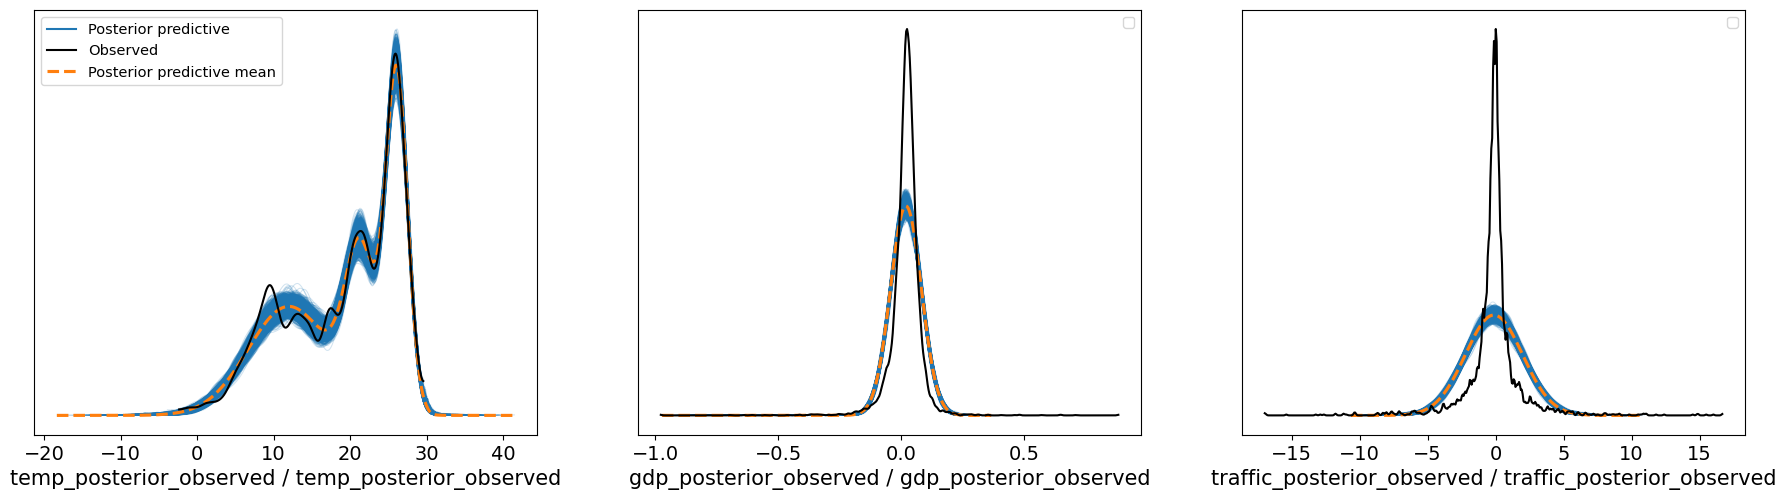

In [106]:
# fig = az.plot_ppc(prior, group="prior").ravel()[0].figure
# fig.show()
# fig = az.plot_trace(trace).ravel()[0].figure
# fig.show()
fig = az.plot_ppc(posterior).ravel()[0].figure
fig.show()

# Preprocess traffic and Burke data and make combined dataset file

In [15]:
burke_data = pd.read_csv("data/burke/GrowthClimateDataset.csv")

In [18]:
data = {"Country":[], "Year":[], "Temp":[], "GDP":[], "GDP_change":[], "GDP_Normalized_By_Country":[], "Precipitation":[]}
year_min = min(burke_data["year"])
year_max = max(burke_data["year"])
for country in sorted(list(set([country for country in burke_data["iso"]]))):
    country_gdp_data = []
    for year in range(year_min, year_max+1):
        data["Country"].append(country)
        data["Year"].append(year)
        try:
            data["Temp"].append(
                burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]["UDel_temp_popweight"].item()
            )
        except ValueError:
            data["Temp"].append(np.NaN)
        try:
            data["GDP"].append(
                burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]["TotGDP"].item()
            )
        except ValueError:
            data["GDP"].append(np.NaN)
        country_gdp_data.append(data["GDP"][-1])
        try:
            data["Precipitation"].append(
                burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]["UDel_precip_popweight"].item()
            )
        except ValueError:
            data["Precipitation"].append(np.NaN)
        try:
            data["GDP_change"].append(
                burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]["growthWDI"].item()
            )
        except ValueError:
            data["GDP_change"].append(np.NaN)
    normalized_gdp_by_country = StandardScaler().fit_transform(np.array(country_gdp_data).reshape(-1, 1)).flatten()
    for elem in normalized_gdp_by_country:
        data["GDP_Normalized_By_Country"].append(elem)
        
pd.DataFrame.from_dict(data).to_csv("data/processed/burke_country_temp_gdp.csv", encoding='utf-8')

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/skle

In [105]:
with open ('models/temp_gdp_traffic.pkl', 'wb') as buff:
    pkl.dump ({'prior': prior, 'trace': trace, "posterior": posterior}, buff)

In [4]:
with open('models/temp_gdp_traffic.pkl', 'rb') as buff:
    data = pkl.load(buff)
    prior = data["prior"]
    trace = data["trace"]
    posterior = data["posterior"]